# Convolutional Sentiment Classifier

In this notebook, we build a *convolutional* neural net to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding

# Convolution layer and related libraries
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64

n_unique_words = 5000 
# Convolution layer is capable of handling more inputs than regular dense layer
# additionally because of max pooling complexity or output dimensionality can be still reduced.
# so we are increasing movie review length to 400. 
max_review_length = 400
pad_type = trunc_type = 'pre'
# convolution layer dropout percentage
drop_embed = 0.2 # new!

# convolutional layer architecture:
# 256 filters
# each filter has length of 3. So it will try to find triplets.
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()

# First Hidden layer:
# Embedding layer:
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
# applying droput to multidimensional output.
model.add(SpatialDropout1D(drop_embed))

# Second Hidden layer:
# Convolution layer
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

# Third Hidden layer:
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# Output layer:
model.add(Dense(1, activation='sigmoid'))

/Users/sshivagangeprakash/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Configure model

In [6]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [7]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [8]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.6467 - loss: 0.5980 - val_accuracy: 0.8630 - val_loss: 0.3138
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.8941 - loss: 0.2600 - val_accuracy: 0.8880 - val_loss: 0.2642
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9365 - loss: 0.1675 - val_accuracy: 0.8933 - val_loss: 0.2658
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9642 - loss: 0.1099 - val_accuracy: 0.8886 - val_loss: 0.2995


In [9]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 400, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 400, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 398, 256)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,306,374 (4.98 MB)

 Trainable params: 435,457 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 870,917 (3.32 MB)

#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.03.keras") 

In [11]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


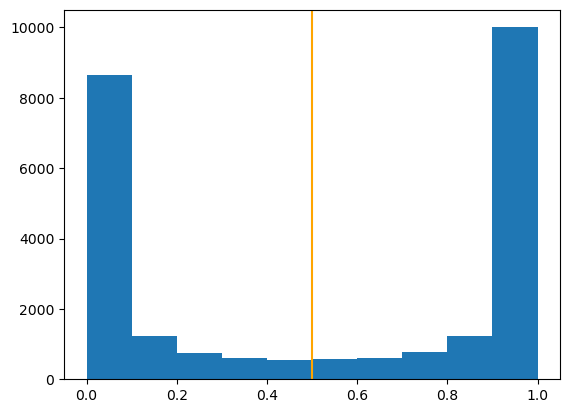

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.07'